#  Predicting Drug Induced Gene Expression

### Project Introduction

This project tackles a core challenge in drug discovery: predicting how a drug will affect a cell's biology before it's ever tested in the lab. 
```
Gene Expression Change = f(Drug, Cell Type)
```
We use the LINCS L1000 (GSE92742) dataset, because it is the gold-standard, largest, and most comprehensive public resource designed for exactly this project's goal: predicting how a cell's gene expression changes in response to a drug. The dataset contains each variable in the equation above:

  * **Gene Expression Change**: It contains the gene expression changes (the Z-scores in the .gctx file).

  * **Drug**: It tells you which drug was used for each experiment (in the sig_info and pert_info files).

  * **Cell Type**: It tells you which cell type was used (also in the sig_info file)

We build a deep generative model to address this challenge by learning how different drugs change gene expression.  Mapping the post-treatment gene expression to a compact latent space using a Variational Autoencoder, the model can ifer a gene expression profile from a novel drug that it has never seen before.

The steps carried out in this notebook include:

  1. **Exploratory Data Analysis (EDA)**: ...
  
  

--- 
### References

**Data Sources and Platforms**

* [LINCS L1000 (GSE92742)](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE92742): The data used here is the LINCS L1000 - the gold-standard, largest and most comprehensive public resource designed for predicting how a cell's gene expression changes in response to a drug.

**Libraries**
* [Pytorch Geometric](https://pytorch-geometric.readthedocs.io/en/latest/)

---
### Table of Contents

1. [Imports](#imports)
2. [Utility Functions](#utility-functions)
3. [Constants & Data Import](#constants-&-data-import)
4. [Data Exploration](#data-exploration)
5. [Data Pre-processing](#data-pre-processing)
6. [Build the Model](#build-the-model) 
7. [Clustering & Visualization](#clustering-&-visualization)
8. [Summary](#summary)

---
### 1. Imports <a class="anchor" id="imports"></a>

In [1]:
import os
from pathlib import Path
from typing import Tuple

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
import squidpy as sq
import random

import pandas as pd
import numpy as np
from cmapPy.pandasGEXpress.parse import parse as parse_gctx

from sklearn.metrics import roc_auc_score

import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling, train_test_split_edges
from tqdm import tqdm

from tqdm.autonotebook import tqdm
from sklearn.preprocessing import StandardScaler

/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/libpyg.so, 0x0006): tried: '/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/libpyg.

---
### 2. Utility Functions <a class="anchor" id="utility"></a>

#### Model Architecture

Define the Variational Autoencoder

In [2]:
pass

#### Training Functions

In [3]:
def train(model, optimizer, data):
    """Train the model for one epoch.

    Returns:
        float: The reconstruction loss on the training edges.
    """
    model.train()
    optimizer.zero_grad()
    z = model.encode(data.x, data.train_pos_edge_index)
    # calculate the loss on the training edges
    loss, auc_score = model.recon_loss(z, data.train_pos_edge_index)

    loss.backward()
    optimizer.step()
    return float(loss), auc_score


@torch.no_grad()
def test(model, data):
    """Evaluate the model on the validation edges.

    Args:
        pos_edge_index (torch.Tensor): The positive edge indices for validation.
    Returns:
        float: The reconstruction loss on the validation edges.
    """
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)

    loss, auc_score = model.recon_loss(z, data.val_pos_edge_index)

    return float(loss), auc_score

---
### 3. Constants & Data Import <a class="anchor" id="constants"></a>


The necessary data files can be accessed and downloaded via the [Gene Expression Omnibus Portal](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE92742). The following specific datasets are required:

* **The Gene Expression Data**

    *GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx.gz* 
    
    The main data matrix that contains the results of nearly half a million experiments (how much a gene's expression went up or down in a single experiment compared to a control)

* **The Signature Info File**

    *GSE92742_Broad_LINCS_sig_info.txt*

    Metadata file that explains what each column in the expression matrix means.

* **The Perturbation Info File**

    *GSE92742_Broad_LINCS_pert_info.txt*

    The drug dictionary that provides details about the perturbations used in the experiments.

* **The Gene Info File**

    *GSE92742_Broad_LINCS_gene_info.txt*

    The gene dictionary that provides details about the genes measured.


The notebook expects both tsv files to be placed in the `data/LINCS_L1000` folder.

In [4]:
ROOT = Path(os.getcwd()).parents[0]

DATA_PATH = os.path.join(ROOT, "data", "LINCS_L1000")
GCTX_DATA_PATH = os.path.join(DATA_PATH, "GSE92742_Broad_LINCS_Level5_COMPZ.MODZ_n473647x12328.gctx")

GENE_INFO_PATH = os.path.join(DATA_PATH, "GSE92742_Broad_LINCS_gene_info.txt")
PERTURBATION_DATA_PATH = os.path.join(DATA_PATH, "GSE92742_Broad_LINCS_pert_info.txt")
SIGNATURE_DATA_PATH = os.path.join(DATA_PATH, "GSE92742_Broad_LINCS_sig_info.txt")

---
### 4. Data Exploration <a class="anchor" id="constants"></a>

#### Load the Metadata

In [5]:
df_per = pd.read_csv(PERTURBATION_DATA_PATH, sep="\t", low_memory=False)
df_sig = pd.read_csv(SIGNATURE_DATA_PATH, sep="\t", low_memory=False)
df_gene = pd.read_csv(GENE_INFO_PATH, sep="\t", low_memory=False)

**Perturbation Data**

The perturbation data provides details about the perturbations used in the experiment.

* **pert_id**: unique, machine-readable ID for the specific perturbation. For example, BRD-K68915174. This ID can be mapped to the sig_info file.

* **pert_iname**: common, human-readable name of the perturbation. For example, for BRD-K68915174 is the same as the pert_id (a development compound), but for others, it might be a common drug name like "vorinostat". For genetic perturbations, it's the gene symbol (e.g., PKIG).

* **pert_type**: what kind of perturbation was used.

    * **trt_cp**: Stands for "Treatment - Compound". This means a small molecule drug was used. 

    * **trt_sh**: Stands for "Treatment - shRNA". This means a gene was knocked down using a genetic tool. 

* **canonical_smiles**: the chemical structure of the drug represented as a SMILES string (a line of text). The -666 is just a placeholder for non-chemical perturbations like shRNAs.

* **inchi_key / inchi_key_prefix**: another type of unique chemical identifier.

* **pubchem_cid**: the compound's ID in PubChem.

* **is_touchstone**: a simple flag (1 or 0). The "touchstone" compounds are a set of well-characterized reference drugs that the LINCS project uses for quality control and comparison.

In [6]:
print(f"Perturbation Data Shape: {df_per.shape}")
display(df_per.sample(5))

Perturbation Data Shape: (51383, 8)


,pert_id,pert_iname,pert_type,is_touchstone,inchi_key_prefix,inchi_key,canonical_smiles,pubchem_cid
23373,CGS001-5744,PTHLH,trt_sh.cgs,1,-666,-666,-666,-666
39657,TRCN0000043413,SLC3A1,trt_sh,1,-666,-666,-666,-666
21606,CGS001-2324,FLT4,trt_sh.cgs,1,-666,-666,-666,-666
8306,BRD-K36156445,BRD-K36156445,trt_cp,0,KJZOGGIMPWHLRO,KJZOGGIMPWHLRO-DGUDUIIESA-N,C[C@@H](CO)N1C[C@H](C)[C@H](CN(C)C(=O)Nc2ccc(c...,54618141
14766,BRD-K70273200,BRD-K70273200,trt_cp,0,XGAGPUGBXVVIKK,XGAGPUGBXVVIKK-GOTSBHOMSA-N,OC[C@@H]1N(Cc2ccccn2)C2(CN(C2)C(=O)c2cccc(F)c2...,60189991


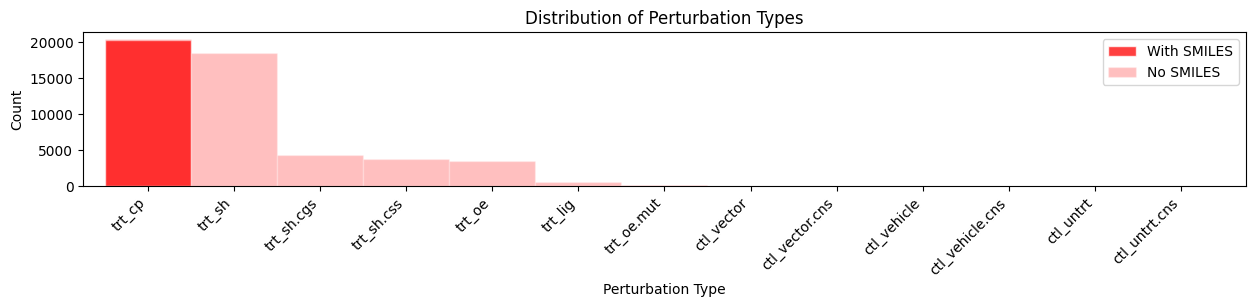

In [7]:
_, axes = plt.subplots(figsize=(15, 2))

df_per[df_per["canonical_smiles"]!="-666"]["pert_type"].value_counts().plot(
    kind="bar", 
    ax=axes,
    width=1,
    color="red",
    edgecolor="white",
    title="Distribution of Perturbation Types",
    xlabel="Perturbation Type",
    ylabel="Count",
    alpha=0.75
)
df_per["pert_type"].value_counts().plot(
    kind="bar", 
    ax=axes,
    width=1,
    color="red",
    edgecolor="white",
    title="Distribution of Perturbation Types",
    xlabel="Perturbation Type",
    ylabel="Count",
    alpha=0.25
)

plt.xticks(rotation=45, ha='right')
plt.legend(["With SMILES", "No SMILES"])
plt.show()


The trt_cp corresponding to small molecules are the only ones that have associated SMILES strings.  These will be used for modeling.

In [8]:
ids_with_smiles = df_per[df_per["canonical_smiles"]!="-666"]["pert_id"]

print(f"Perturbations with SMILES: {len(ids_with_smiles)} ({100*len(ids_with_smiles)/df_per.shape[0]:.2f}%)")

Perturbations with SMILES: 20351 (39.61%)


**Signature Data**

The signature data provides details about the experiments performed with each row corresponding to a single column in the gene expression matrix.

* **sig_id**: the unique ID for this specific experiment signature. It's the primary key used to find this experiment's column in the main gene expression data file.

* **pert_id**: the ID for the perturbation (the drug) that was used. This ID can be used to look up the drug's chemical structure in the pert_info file.

* **pert_iname**: common, human-readable name of the drug. Here, it's tanespimycin.

* **pert_type**: what kind of perturbation was used.

    * **trt_cp**: Stands for "Treatment - Compound". This means a small molecule drug was used. 

    * **trt_sh**: Stands for "Treatment - shRNA". This means a gene was knocked down using a genetic tool. 

* **cell_id**: name of the cell line that was treated.

* **pert_dose / pert_idose**: dosage of the drug. pert_dose is the numerical value (e.g., 0.35), and pert_idose is the more descriptive string (e.g., 500 nM).

* **pert_time / pert_itime**: duration of the treatment. pert_time is the numerical value (e.g., 6), and pert_itime includes the unit (e.g., 6 h).

* **distil_id**: internal ID used by the Broad Institute for their data processing pipeline.

In [9]:
print(f"Signature Data Shape: {df_sig.shape}")
display(df_sig.sample(5))

Signature Data Shape: (473647, 12)


,sig_id,pert_id,pert_iname,pert_type,cell_id,pert_dose,pert_dose_unit,pert_idose,pert_time,pert_time_unit,pert_itime,distil_id
324610,KDB005_ASC_96H:TRCN0000045738:-666,TRCN0000290719,ALAS1,trt_sh,ASC,6,µL,6 µL,96,h,96 h,KDB005_ASC_96H_X1_B6_DUO52HI53LO:O09|KDB005_AS...
8536,CGS001_A549_96H:RGS2:1,CGS001-5997,RGS2,trt_sh.cgs,A549,1.0,µL,1 µL,96,h,96 h,KDB007_A549_96H:TRCN0000000220:-666|KDB007_A54...
402492,KDD006_PC3_96H:TRCN0000315200:-666,TRCN0000315200,FBXW11,trt_sh,PC3,2.0,µL,2 µL,96,h,96 h,KDD006_PC3_96H_X1_B4_DUO52HI53LO:P20|KDD006_PC...
114847,CPC013_MCF7_6H:BRD-K23027438-001-01-1:10,BRD-K23027438,BRD-K23027438,trt_cp,MCF7,10.0,µM,10 µM,6,h,6 h,CPC013_MCF7_6H_X1_B4_DUO52HI53LO:O01|CPC013_MC...
202595,DOS019_VCAP_6H:BRD-K73096266-001-01-2:5.01,BRD-K73096266,BRD-K73096266,trt_cp,VCAP,5.01,µM,5 µM,6,h,6 h,DOS019_VCAP_6H_X4_F1B6_DUO52HI53LO:P07|DOS019_...


In [10]:
sig_ids_with_smiles = df_sig[df_sig["pert_id"].isin(ids_with_smiles)]["sig_id"]

print(f"Experiments with SMILES: {len(sig_ids_with_smiles)} ({100*len(sig_ids_with_smiles)/df_sig.shape[0]:.2f}%)")

Experiments with SMILES: 217572 (45.94%)


**Gene Data**

The gene data provides metadata about every gene measured in the LINCS L1000 project.

* **pr_gene_id**: the primary numerical ID for the gene (e.g., 21305909). This is the ID that will be used as the row index in the main expression data matrix

* **pr_gene_symbol**: the official, human-readable gene symbol that could be used in a publication or look up in a database.

* **pr_gene_title**: a longer, more descriptive name for the gene, often giving a hint about its function (e.g., RAP1 GTPase activating protein).

* **pr_is_lm**: an important flag that stands for "is landmark".

    * A value of 1 means this is one of the ~1000 "landmark" genes whose expression was directly measured by the L1000 assay.

    * A value of 0 means this gene's expression was inferred computationally from the landmark genes.

* **pr_is_bing**: This stands for "is Best INferred Gene".

    * A value of 1 indicates that this gene is part of a set of ~10,000 genes whose expression can be inferred with high confidence from the landmark genes.

In [11]:
print(f"Gene Data Shape: {df_gene.shape}")
display(df_gene.sample(5))

Gene Data Shape: (12328, 5)


,pr_gene_id,pr_gene_symbol,pr_gene_title,pr_is_lm,pr_is_bing
3035,5051,PAFAH2,platelet-activating factor acetylhydrolase 2,0,1
8323,249,ALPL,"alkaline phosphatase, liver/bone/kidney",0,1
1101,522,ATP5J,"ATP synthase, H+ transporting, mitochondrial F...",0,1
2532,5534,PPP3R1,"protein phosphatase 3 regulatory subunit B, alpha",0,1
10474,10743,RAI1,retinoic acid induced 1,0,0


#### Filter the dataset

Because the data is so large, and a drugs effect can be different on different cell lines, simplify the problem and filter down to a more narrow group of experiments

In [33]:
# merge the perturbation and signature data
df_merged = pd.merge(
    df_per, 
    df_sig.drop(columns=["pert_iname", "pert_type"]), 
    left_on="pert_id", 
    right_on="pert_id", 
    how="left"
)
df_merged.shape

(473795, 17)

In [36]:
# select a single cell line 
CELL_LINE = "MCF7" # MCF7 is a well-characterized breast cancer cell line
PERT_TIME = 24 # 24 hours is a common treatment time in drug response studies
PERT_DOSE = "10.0" # 10 uM is a common dose in drug response studies

# keep only chemical compounds
df_merged = df_merged[df_merged["pert_type"] == "trt_cp"].copy()

# keep only experiments with SMILES
df_merged = df_merged[df_merged["sig_id"].isin(sig_ids_with_smiles)].copy()

# select a single cell line
df_merged = df_merged[df_merged["cell_id"] == CELL_LINE].copy()

# filter down to a single treatment time 
df_merged = df_merged[df_merged["pert_time"] == PERT_TIME].copy()

# filter down to a single dose
df_merged = df_merged[df_merged["pert_dose"] == PERT_DOSE].copy()

df_merged.shape

(7282, 17)

There are perturbations that have been run more than once at the same pert_time and pert_dose by design.  Average the results of these replicates to get a single, more robust gene expression signature for each unique treatment

In [38]:
df_merged["pert_id"].value_counts().iloc[:5]

pert_id
BRD-K81418486    60
BRD-A19500257    51
BRD-A19037878    51
BRD-A75409952    49
BRD-K18910433    12
Name: count, dtype: int64

In [ ]:
df_merged[df_merged["pert_id"]=="BRD-K81418486"].iloc[:5]

,pert_id,pert_iname,pert_type,is_touchstone,inchi_key_prefix,inchi_key,canonical_smiles,pubchem_cid,sig_id,cell_id,pert_dose,pert_dose_unit,pert_idose,pert_time,pert_time_unit,pert_itime,distil_id
171182,BRD-K81418486,vorinostat,trt_cp,1,WAEXFXRVDQXREF,WAEXFXRVDQXREF-UHFFFAOYSA-N,ONC(=O)CCCCCCC(=O)Nc1ccccc1,-666,ASG001_MCF7_24H:BRD-K81418486-001-24-4:10,MCF7,10.0,µM,10 µM,24.0,h,24 h,ASG001_MCF7_24H_X1_B7_DUO52HI53LO:A05|ASG001_M...
171257,BRD-K81418486,vorinostat,trt_cp,1,WAEXFXRVDQXREF,WAEXFXRVDQXREF-UHFFFAOYSA-N,ONC(=O)CCCCCCC(=O)Nc1ccccc1,-666,CPC005_MCF7_24H:BRD-K81418486:10,MCF7,10.0,µM,10 µM,24.0,h,24 h,CPC005_MCF7_24H_X1_B4_DUO52HI53LO:B04|CPC005_M...
171313,BRD-K81418486,vorinostat,trt_cp,1,WAEXFXRVDQXREF,WAEXFXRVDQXREF-UHFFFAOYSA-N,ONC(=O)CCCCCCC(=O)Nc1ccccc1,-666,CPC006_MCF7_24H:BRD-K81418486:10,MCF7,10.0,µM,10 µM,24.0,h,24 h,CPC006_MCF7_24H_X1_B4_DUO52HI53LO:B04|CPC006_M...
171398,BRD-K81418486,vorinostat,trt_cp,1,WAEXFXRVDQXREF,WAEXFXRVDQXREF-UHFFFAOYSA-N,ONC(=O)CCCCCCC(=O)Nc1ccccc1,-666,CPC007_MCF7_24H:BRD-K81418486-001-21-0:10,MCF7,10.0,µM,10 µM,24.0,h,24 h,CPC007_MCF7_24H_X1_B5_DUO52HI53LO:H18|CPC007_M...
171399,BRD-K81418486,vorinostat,trt_cp,1,WAEXFXRVDQXREF,WAEXFXRVDQXREF-UHFFFAOYSA-N,ONC(=O)CCCCCCC(=O)Nc1ccccc1,-666,CPC007_MCF7_24H:BRD-K81418486:10,MCF7,10.0,µM,10 µM,24.0,h,24 h,CPC007_MCF7_24H_X1_B5_DUO52HI53LO:D02|CPC007_M...


In [41]:
replicate_groups = df_merged.groupby(['pert_id', 'cell_id', 'pert_dose', 'pert_time'])['sig_id'].apply(list)
print(f"Found {len(replicate_groups)} unique drug treatments in the filtered set.")

Found 5741 unique drug treatments in the filtered set.


#### Load the Gene Matrix

* Each row represents a gene that is marked by a row id (rid) and can be mapped to a specific pr_gene_id in the `gene_info.txt` file.

* Each column represents a unique experiment that is marked by a col id (cid) that can be mapped to a specific sig_id in the `sig_info.txt` file.

* The values of the dataframe are normalized gene expression values indicating how much the genes expression changed in that experiment compared to its control.


In [42]:
col_metadata_df = parse_gctx(GCTX_DATA_PATH, col_meta_only=True)
all_sig_ids = col_metadata_df.index.tolist()
# Ensure that the number of signature IDs matches the number of signatures in the metadata
assert len(all_sig_ids) == df_sig.shape[0], "Signature IDs do not match the number of signatures in the metadata."

/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/cmapPy/pandasGEXpress/parse_gctx.py:275: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  meta_df = meta_df.apply(lambda x: pd.to_numeric(x, errors="ignore"))


Read in the experiments from our filtered set.

In [44]:
filtered_sig_ids = set(df_merged["sig_id"].tolist())
filtered_sig_ids = list(filtered_sig_ids)

batch_gctoo = parse_gctx(GCTX_DATA_PATH, cid=filtered_sig_ids)
df_all = batch_gctoo.data_df

df_all

/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/cmapPy/pandasGEXpress/parse_gctx.py:275: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  meta_df = meta_df.apply(lambda x: pd.to_numeric(x, errors="ignore"))
/Users/dantrainer/miniconda3/envs/cancer_env/lib/python3.11/site-packages/cmapPy/pandasGEXpress/parse_gctx.py:275: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  meta_df = meta_df.apply(lambda x: pd.to_numeric(x, errors="ignore"))


cid,CPC005_MCF7_24H:BRD-A85280935-003-01-7:10,CPC005_MCF7_24H:BRD-A07824748-001-02-6:10,CPC005_MCF7_24H:BRD-K62929068-001-03-3:10,CPC005_MCF7_24H:BRD-K43405658-001-01-8:10,CPC005_MCF7_24H:BRD-K51223576-001-01-3:10,CPC005_MCF7_24H:BRD-A56675431-001-07-3:10,CPC005_MCF7_24H:BRD-K53979406-003-01-0:10,CPC005_MCF7_24H:BRD-K59419204-001-01-9:10,CPC005_MCF7_24H:BRD-A10969569-001-02-0:10,CPC005_MCF7_24H:BRD-K93188295-300-01-4:10,...,PCLB003_MCF7_24H:BRD-K18910433-001-26-7:10,PCLB003_MCF7_24H:BRD-K10466330-001-01-5:10,PCLB003_MCF7_24H:BRD-K64024097-001-02-8:10,PCLB003_MCF7_24H:BRD-K64106162-001-02-3:10,PCLB003_MCF7_24H:BRD-K16956545-001-01-0:10,PCLB003_MCF7_24H:BRD-K78431006-001-05-2:10,PCLB003_MCF7_24H:BRD-K63828191-003-23-0:10,PCLB003_MCF7_24H:BRD-K93754473-001-17-7:10,PCLB003_MCF7_24H:BRD-A52530684-003-01-7:10,PCLB003_MCF7_24H:BRD-A75409952-001-01-6:10
rid,,,,,,,,,,,,,,,,,,,,,
5720,-1.104279,-0.528817,0.165054,0.476758,0.235163,0.958309,0.439196,-0.308231,0.104582,0.289858,...,0.408504,0.383020,-0.646509,-0.240290,0.620854,-3.980333,1.931547,0.959719,0.125062,0.759589
466,-0.599829,1.063340,0.284834,0.727595,0.135943,0.846429,0.617767,0.952338,0.160561,0.387704,...,0.038143,-0.550278,0.730840,0.555458,-0.284504,-1.315245,0.619591,0.603761,-1.004396,-0.521165
6009,-0.095145,-0.051789,0.062587,-0.277198,-0.456056,0.625077,-0.583521,1.825451,0.370851,0.025000,...,0.741935,-0.148313,-0.065952,-0.751291,-0.376631,0.056077,1.136003,-1.322105,-1.071686,-0.377549
2309,-0.860346,-0.510285,0.488071,0.526337,-0.239833,0.269320,-0.199183,-0.765607,-0.058502,0.489323,...,0.766322,0.831062,-1.769938,0.501619,0.055693,-0.682625,1.080649,0.906715,-3.651138,0.760989
387,0.217769,-0.565834,1.480492,-1.015886,-0.060120,-0.036727,-0.011962,1.216686,2.506466,0.483103,...,-0.008809,-0.688036,0.166454,0.543517,0.555517,0.244966,-1.080103,-1.299324,-0.237515,-1.356615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25960,0.328582,0.419994,-0.241987,0.084392,-0.974077,-0.160104,-0.540925,0.294646,0.105965,-0.426425,...,-0.087192,0.078598,-0.666870,-1.579032,-0.367859,2.986682,0.939099,1.081014,2.446496,-0.235872
6376,-0.046019,0.177152,0.445787,0.576276,-0.487290,-0.614598,-0.585658,0.269142,0.208898,-0.584540,...,0.358291,-0.071163,-0.386082,-0.733569,0.324683,1.697510,-0.536460,0.359322,-2.395238,-0.253197
11033,0.100488,0.190962,0.070305,0.336541,-0.771395,-0.149504,-0.396110,-0.269956,0.044100,-0.176512,...,-0.185066,0.620990,0.073720,0.103451,0.748153,0.789289,0.102311,0.312286,2.055273,1.563955


#### Average all Replicate Experiments

In [ ]:
sig_to_pert_mapping = df_merged.set_index("sig_id")["pert_id"].to_dict() 
df_averaged = df_all.T.groupby(sig_to_pert_mapping).mean()
df_averaged = df_averaged.T

df_averaged

cid,BRD-A00100033,BRD-A00267231,BRD-A00420644,BRD-A00474148,BRD-A00520476,BRD-A00546892,BRD-A00626522,BRD-A00758722,BRD-A00827783,BRD-A00993607,...,BRD-U44700465,BRD-U51951544,BRD-U66370498,BRD-U68942961,BRD-U73238814,BRD-U82589721,BRD-U86922168,BRD-U88459701,BRD-U94846492,BRD-U97083655
rid,,,,,,,,,,,,,,,,,,,,,
5720,0.826567,-0.568241,-2.189991,0.723845,-0.48505,0.217919,-0.55540,-1.264430,0.491229,0.112275,...,-0.392551,-1.33120,-0.045422,-2.841073,0.458586,-1.574413,-3.381999,0.130841,0.267506,0.331280
466,0.284471,0.703532,-1.198357,-0.820021,-0.92530,-0.103425,0.32280,-0.494967,0.465437,0.260624,...,-1.391037,-2.67475,-0.051166,-3.271909,0.744136,-1.011487,-0.525395,-0.857952,0.781003,0.622388
6009,-0.549101,0.357067,2.009591,-0.113706,-1.59015,-0.367488,-0.28730,0.466556,0.675874,-0.027216,...,0.356503,-1.95965,0.042122,-0.231894,-0.291170,-0.020680,-0.311100,-0.676564,0.352920,0.284077
2309,-1.414383,-1.305485,2.530965,0.136478,-1.78720,0.285799,-0.02985,-0.001455,-1.215721,-0.088118,...,1.337993,-4.38085,-0.963460,2.582773,0.101156,-1.336719,3.039191,0.261088,0.087820,-0.649788
387,0.298028,-0.370013,0.410572,-0.210709,-0.47810,-0.101240,0.43780,-0.099972,-0.004129,-0.588786,...,0.965211,0.41375,-0.774725,-0.044668,-0.188228,0.754848,-0.368882,3.442191,0.252630,0.016547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25960,-0.702823,0.389050,0.411424,-0.375076,0.57180,0.207068,-0.14505,0.373843,0.198210,0.499721,...,-0.982736,2.61460,1.613346,-0.272428,-0.980646,0.781393,0.193665,-1.372155,-0.219194,-0.114598
6376,-1.135657,0.010203,0.590206,-0.765630,-0.39100,-0.374216,0.10400,-0.246971,0.398666,-0.416996,...,0.343912,0.95975,1.310484,0.017481,0.295986,-0.653096,-0.083449,0.203162,0.817905,-0.229802
11033,-1.214979,-0.113850,1.304059,0.163355,1.75985,0.486852,-0.78950,-0.738267,0.093434,-0.203176,...,-0.411790,1.12640,0.493943,-0.023583,-1.088944,1.204358,1.144818,-0.604002,0.679328,-0.367433


In [131]:
replicate_groups.reset_index()['pert_id'].iloc[2]

'BRD-A00420644'

In [124]:
replicate_groups.reset_index()['sig_id'].iloc[2]

['CPC019_MCF7_24H:BRD-A00420644-001-01-7:10',
 'MUC.CP003_MCF7_24H:BRD-A00420644-001-01-7:10']

In [133]:
df_averaged["BRD-A00420644"][:3]

rid
5720   -2.189991
466    -1.198357
6009    2.009591
Name: BRD-A00420644, dtype: float32

In [127]:
df_all[replicate_groups.reset_index()['sig_id'].iloc[2]].mean(axis=1).iloc[:3]

rid
5720   -2.189991
466    -1.198357
6009    2.009591
dtype: float32

In [129]:
df_all[replicate_groups.reset_index()['sig_id'].iloc[2]].iloc[:3]

cid,CPC019_MCF7_24H:BRD-A00420644-001-01-7:10,MUC.CP003_MCF7_24H:BRD-A00420644-001-01-7:10
rid,,
5720,-3.290983,-1.0890
466,-0.689514,-1.7072
6009,1.876182,2.1430


In [118]:
pert_to_sig_mapping['BRD-A00420644']

'MUC.CP003_MCF7_24H:BRD-A00420644-001-01-7:10'

In [87]:
df_averaged = pd.DataFrame()
df_replicated = replicate_groups.reset_index()

for row in tqdm(df_replicated.iterrows(), total = df_replicated.shape[0], desc="Averaging replicates"):

    duplicate_sig_ids = row[1]['sig_id']
    df_to_append = df_all[duplicate_sig_ids].mean(axis=1)
    
    df_averaged = pd.concat([df_averaged, df_to_append], axis=1)

df_averaged

Averaging replicates:  46%|████▌     | 2632/5741 [01:30<01:46, 29.24it/s]


KeyboardInterrupt: 

0       BRD-A00100033
1       BRD-A00267231
2       BRD-A00420644
3       BRD-A00474148
4       BRD-A00520476
            ...      
5736    BRD-U82589721
5737    BRD-U86922168
5738    BRD-U88459701
5739    BRD-U94846492
5740    BRD-U97083655
Name: pert_id, Length: 5741, dtype: object

#### Perform Basic EDA on Gene Expression Data

**What is the overall distribution of the gene expression Z-scores?**

The data is described as "Level 5 Z-scores," which implies it has been normalized. We expect the distribution of all values in the matrix to look like a standard normal distribution.

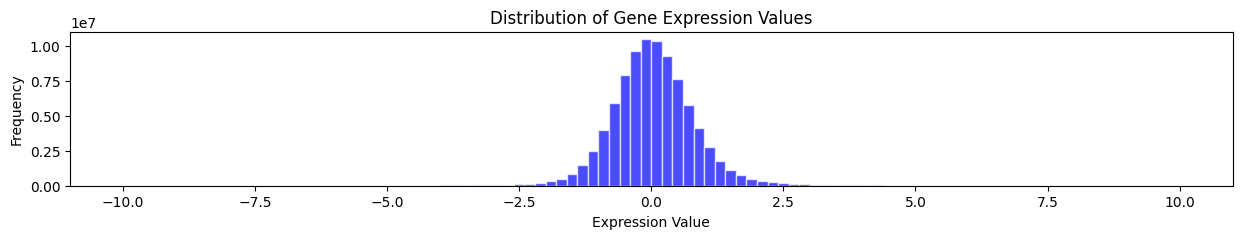

In [45]:
_, axes = plt.subplots(figsize=(15, 2))
plt.hist(
    df_all.values.flatten(),
    bins=100,
    color="blue",
    edgecolor="white",
    alpha=0.7
)
plt.title("Distribution of Gene Expression Values")
plt.xlabel("Expression Value")
plt.ylabel("Frequency");

**Which genes are the most "volatile" across all drug treatments?**

Determnine which genes are most commonly affected by drug perturbations, regardless of the specific drug.

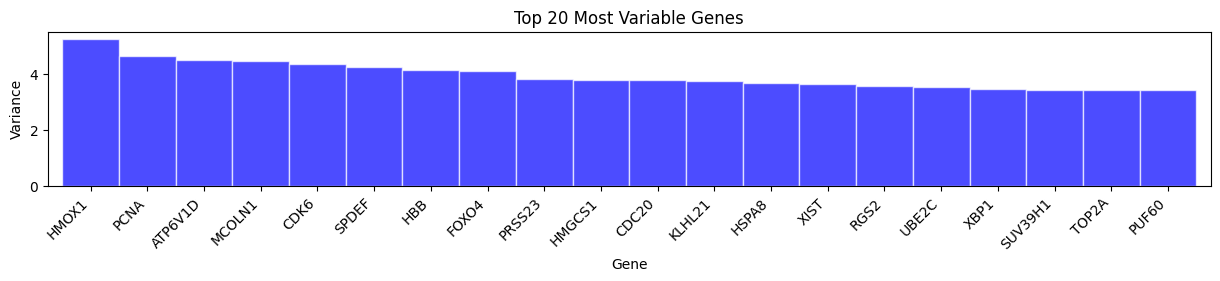

In [46]:
id_to_gene_mapping = df_gene.set_index("pr_gene_id")["pr_gene_symbol"].to_dict()
df_top_var_genes = df_all.var(axis=1).sort_values(ascending=False).head(20)

_, axes = plt.subplots(figsize=(15, 2))

df_top_var_genes.index = df_top_var_genes.index.astype(int).map(id_to_gene_mapping)
df_top_var_genes.plot(
    kind="bar",
    width=1,
    ax=axes,
    color="blue",
    edgecolor="white",
    title="Top 20 Most Variable Genes",
    xlabel="Gene",
    ylabel="Variance",
    alpha=0.7
)
plt.xticks(rotation=45, ha='right')
plt.show()

**How do different drugs affect a single gene?**

Check the range of effects on a specific biological pathway. For example, is a famous cancer gene like CDC20 (Cell Division Cycle 20 - crucial regulator of the cell cycle controling the progression of mitosis) up-regulated by many drugs, or only a specific few?

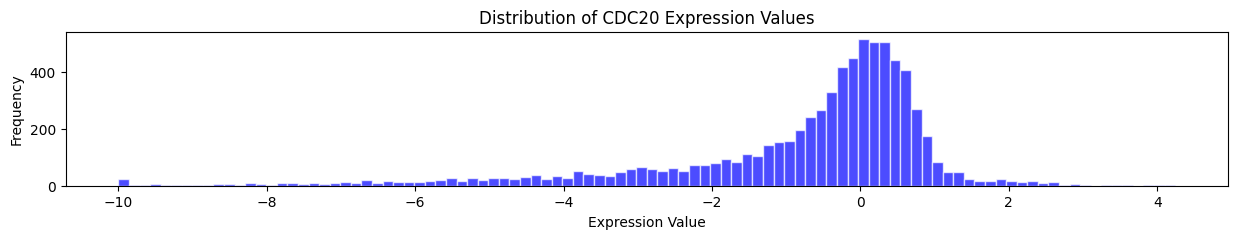

In [47]:
gene_to_id_mapping = {v: k for k, v in id_to_gene_mapping.items()}
cdc20_id = gene_to_id_mapping.get("CDC20")

_, axes = plt.subplots(figsize=(15, 2))
plt.hist(
    df_all.loc[str(cdc20_id)],
    bins=100,
    color="blue",
    edgecolor="white",
    alpha=0.7
)
plt.title("Distribution of CDC20 Expression Values")
plt.xlabel("Expression Value")
plt.ylabel("Frequency")
plt.show()

**How similar are the effects of different drugs?**

If two different drugs produce very similar gene expression profiles, it strongly suggests they have a similar mechanism of action.

In [48]:
df_all

cid,CPC005_MCF7_24H:BRD-A85280935-003-01-7:10,CPC005_MCF7_24H:BRD-A07824748-001-02-6:10,CPC005_MCF7_24H:BRD-K62929068-001-03-3:10,CPC005_MCF7_24H:BRD-K43405658-001-01-8:10,CPC005_MCF7_24H:BRD-K51223576-001-01-3:10,CPC005_MCF7_24H:BRD-A56675431-001-07-3:10,CPC005_MCF7_24H:BRD-K53979406-003-01-0:10,CPC005_MCF7_24H:BRD-K59419204-001-01-9:10,CPC005_MCF7_24H:BRD-A10969569-001-02-0:10,CPC005_MCF7_24H:BRD-K93188295-300-01-4:10,...,PCLB003_MCF7_24H:BRD-K18910433-001-26-7:10,PCLB003_MCF7_24H:BRD-K10466330-001-01-5:10,PCLB003_MCF7_24H:BRD-K64024097-001-02-8:10,PCLB003_MCF7_24H:BRD-K64106162-001-02-3:10,PCLB003_MCF7_24H:BRD-K16956545-001-01-0:10,PCLB003_MCF7_24H:BRD-K78431006-001-05-2:10,PCLB003_MCF7_24H:BRD-K63828191-003-23-0:10,PCLB003_MCF7_24H:BRD-K93754473-001-17-7:10,PCLB003_MCF7_24H:BRD-A52530684-003-01-7:10,PCLB003_MCF7_24H:BRD-A75409952-001-01-6:10
rid,,,,,,,,,,,,,,,,,,,,,
5720,-1.104279,-0.528817,0.165054,0.476758,0.235163,0.958309,0.439196,-0.308231,0.104582,0.289858,...,0.408504,0.383020,-0.646509,-0.240290,0.620854,-3.980333,1.931547,0.959719,0.125062,0.759589
466,-0.599829,1.063340,0.284834,0.727595,0.135943,0.846429,0.617767,0.952338,0.160561,0.387704,...,0.038143,-0.550278,0.730840,0.555458,-0.284504,-1.315245,0.619591,0.603761,-1.004396,-0.521165
6009,-0.095145,-0.051789,0.062587,-0.277198,-0.456056,0.625077,-0.583521,1.825451,0.370851,0.025000,...,0.741935,-0.148313,-0.065952,-0.751291,-0.376631,0.056077,1.136003,-1.322105,-1.071686,-0.377549
2309,-0.860346,-0.510285,0.488071,0.526337,-0.239833,0.269320,-0.199183,-0.765607,-0.058502,0.489323,...,0.766322,0.831062,-1.769938,0.501619,0.055693,-0.682625,1.080649,0.906715,-3.651138,0.760989
387,0.217769,-0.565834,1.480492,-1.015886,-0.060120,-0.036727,-0.011962,1.216686,2.506466,0.483103,...,-0.008809,-0.688036,0.166454,0.543517,0.555517,0.244966,-1.080103,-1.299324,-0.237515,-1.356615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25960,0.328582,0.419994,-0.241987,0.084392,-0.974077,-0.160104,-0.540925,0.294646,0.105965,-0.426425,...,-0.087192,0.078598,-0.666870,-1.579032,-0.367859,2.986682,0.939099,1.081014,2.446496,-0.235872
6376,-0.046019,0.177152,0.445787,0.576276,-0.487290,-0.614598,-0.585658,0.269142,0.208898,-0.584540,...,0.358291,-0.071163,-0.386082,-0.733569,0.324683,1.697510,-0.536460,0.359322,-2.395238,-0.253197
11033,0.100488,0.190962,0.070305,0.336541,-0.771395,-0.149504,-0.396110,-0.269956,0.044100,-0.176512,...,-0.185066,0.620990,0.073720,0.103451,0.748153,0.789289,0.102311,0.312286,2.055273,1.563955


**Observations**: 
* ...

---
### 6. Build the Model <a class="anchor" id="model"></a>

Define model parameters

**Observations**:
- ...

---
### 8. Summary

This project demonstrates ...


The primary findings include:

* ...

Next Steps:
* Investigate the effect of ...